# Import

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 11.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import re
import numpy as np

from gensim.models import FastText
import pickle
import multiprocessing

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, GlobalMaxPool1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical, pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras_tuner.tuners import Hyperband
from keras import backend as K

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc

# corpus

In [ ]:
ar1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PFE/corpus/ar1.csv')
ar1.head()

,text
0,ممتاز البوفيه المفتوح راءع جدا سواء الفطور او ...
1,كتاب حكم النبي محمد كتبه الاديب الرواءي الروسي...
2,معلومات تاريخيه الثوره الايرانيه حدث بتفاصيل م...
3,جلال امين يجد اجابه للسءال فاخد يسرد قصصا تسوق...
4,شقه ممتازه اعجبني شيء وخاصه طاقم العمل


In [ ]:
ar2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PFE/corpus/ar2.csv')
ar2.head()

,text
0,احد اسباب نجاح الامارات ان شخص الدوله يعشق ترا...
1,هادفه وقويه تنقلك صخب شوارع القاهره الي هدوء ...
2,خلصنا مبدءيا اللي مستني ابهار زي الفيل الازرق...
3,ياسات جلوريا جزء يتجزا دبي فندق متكامل الخدما...
4,اسلوب الكاتب راءع جدا عميق جدا قراته عده مرات ...


In [ ]:
dz1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PFE/corpus/dz1.csv')
dz1.head()

,text
0,فضلكم اتفرجو الفيديو كامل الاول للاخر تسالو عل...
1,نزيد نجاح
2,الباتري تاعو 50
3,😍براك الله فيك
4,اخينخوس ريدمي 9 مالقتوش


In [ ]:
dz2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PFE/corpus/dz2.csv')
dz2.head()

,text
0,شعب مريض باينه بلي اوروبا سيارات رخاص لانه انت...
1,اضرب اليورو الدينار التونسي الاسعار عدنا تونس ...
2,اسعار السيارات نوعها معقوله جدا
3,مول الجاراج تحسو دزيري مغليهم ياسر
4,🌙 💦 🌹الهم صل علي سيدنا 💛محمد 💛الذي تحولت ا...


In [ ]:
Final = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PFE/corpus/Final2.csv')
Final.head()

,text
0,فرنسيه تاعك طربڨ 😅 😅فات شهر والو
1,واش انتم ولاد فرنسا
2,قنوات الجزاير بدون ترجمه نتوما خير سبوره واله ...
3,جاز شهر ماكانش الاسعار كيما قلتو علاه تكذبو
4,الغه الفرنسيه تجري عروقهم لاحول قوه الا باله


In [ ]:
lst = [ar1, ar2, dz1, dz2, Final]  # List of your dataframes
corpus= pd.concat(lst, ignore_index=True)

In [ ]:
corpus.shape

(600443, 1)

In [ ]:
corpus = corpus.dropna(axis=0)

In [ ]:
corpus.text = corpus.text.astype(str)

In [ ]:
corpus = corpus.drop_duplicates()

In [ ]:
corpus.shape

(490734, 1)

In [ ]:
corpus.head()

,text
0,ممتاز البوفيه المفتوح راءع جدا سواء الفطور او ...
1,كتاب حكم النبي محمد كتبه الاديب الرواءي الروسي...
2,معلومات تاريخيه الثوره الايرانيه حدث بتفاصيل م...
3,جلال امين يجد اجابه للسءال فاخد يسرد قصصا تسوق...
4,شقه ممتازه اعجبني شيء وخاصه طاقم العمل


,text
0,ممتاز البوفيه المفتوح راءع جدا سواء الفطور او ...
1,كتاب حكم النبي محمد كتبه الاديب الرواءي الروسي...
2,معلومات تاريخيه الثوره الايرانيه حدث بتفاصيل م...
3,جلال امين يجد اجابه للسءال فاخد يسرد قصصا تسوق...
4,شقه ممتازه اعجبني شيء وخاصه طاقم العمل


#FastText training

In [ ]:
text = corpus['text'].apply(lambda x: x.split())

In [ ]:
Embedding_dimensions = 300

In [ ]:
cores = multiprocessing.cpu_count()
print(cores)

In [ ]:
# Defining the model and training it.
fasttext_model = FastText(text,
                 vector_size=Embedding_dimensions,
                 workers=2,
                 min_count=2)

In [ ]:
len(fasttext_model.wv)

In [ ]:
fasttext_model.train(text, total_examples= len(text),epochs=21)

In [ ]:
fasttext_model.save("/content/drive/MyDrive/Colab Notebooks/PFE/fasttext_model.bin")

In [ ]:
fasttext_model = FastText.load('/content/drive/MyDrive/Colab Notebooks/PFE/fasttext_model.bin')

In [ ]:
fasttext_model.wv.most_similar(positive=["بزاف"])

[('بزاف\u2066', 0.9472997188568115),
 ('بزاف،', 0.9422277212142944),
 ('بلبزاف', 0.856670081615448),
 ('بزااف', 0.8493159413337708),
 ('بززاف', 0.8441769480705261),
 ('وبزاف', 0.8263711333274841),
 ('لبزاف', 0.8197468519210815),
 ('بزاافف', 0.7961998581886292),
 ('بزاغ', 0.7693771719932556),
 ('بزافربي', 0.7129154801368713)]

# Classification DATA

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PFE/preprocess2FinalBalanced.csv')

In [ ]:
df=df.dropna()

In [ ]:
df.text=df.text.astype(str)

In [ ]:
df = df.drop_duplicates()

In [ ]:
df.shape

(21890, 2)

In [ ]:
df['sentiment'].value_counts()

negative    7304
neutral     7304
positive    7282
Name: sentiment, dtype: int64

In [ ]:
label_mapping = {'positive': 2, 'negative': 0, 'neutral': 1}
df['sentiment'] =[label_mapping[label] for label in df['sentiment']]

In [ ]:
df.head()

,sentiment,text
0,2,♥️ ♥️ ♥️ ♥️ ♥️ ♥️ ♥️ ♥️ ♥️ ♥️ ♥️ ♥️...
1,2,فرانكا هارمت دجدادنا وا والدينا وا مين باعد ول...
2,2,اله يبارك ،هدا الخير ويقولوا الجزايري ماشي خدا...
3,2,بونجور دوك قو ك سويت على ال الموقع (المواقع فر...
4,2,ديدو الدوله حبيبي حاله ازمه ماليه الازمه باقي ...


# Machine Learning

In [ ]:
fasttext_model = FastText.load('/content/drive/MyDrive/Colab Notebooks/PFE/fasttext_model.bin')

In [ ]:
sentences = df['text'].tolist()
labels = df['sentiment'].tolist()

In [ ]:
# Convert a sentence to a feature vector
def sentence_to_vec(sentence):
  sentence = sentence.split()
  vectors = []
  for word in sentence:
    if word in fasttext_model.wv:
      vectors.append(fasttext_model.wv[word])

  if len(vectors) > 0:
      return np.mean(vectors, axis=0)
  else:
      return np.zeros(fasttext_model.vector_size)

# Convert all sentences to feature vectors
X = [sentence_to_vec(sentence) for sentence in sentences]

In [ ]:
# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=21)

In [ ]:
models=[]
class_names=["negative","neutral","positive"]

def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment')

## SVM

In [ ]:
svm = SVC(kernel='linear')
svm.fit(x_train, y_train)
pred=svm.predict(x_test)
print("svm accuracy: ",accuracy_score(y_test, pred))
print("svm f1: ",f1_score(y_test, pred, average='weighted'))

with open('svm.pkl', 'wb') as file:
    pickle.dump(svm, file)

models.append('svm.pkl')

svm accuracy:  0.7348104157149383
svm f1:  0.7357919317468578


In [ ]:
print("svm classification report")
print(classification_report(y_test, pred))

svm classification report
              precision    recall  f1-score   support

           0       0.71      0.77      0.74      1480
           1       0.65      0.65      0.65      1444
           2       0.85      0.78      0.81      1454

    accuracy                           0.73      4378
   macro avg       0.74      0.73      0.74      4378
weighted avg       0.74      0.73      0.74      4378



svm confusion matrix


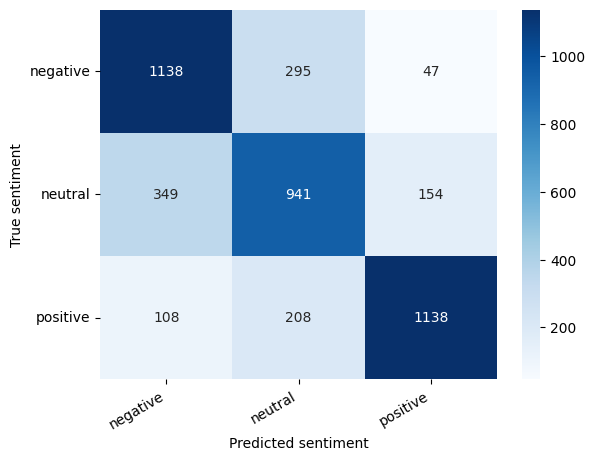

In [ ]:
print("svm confusion matrix")
cm = confusion_matrix(y_test, pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

## Naive Bayes

In [ ]:
bnb = BernoulliNB()
bnb.fit(x_train, y_train)
pred=bnb.predict(x_test)
print("bnb accuracy: ",accuracy_score(y_test, pred))
print("bnb f1: ",f1_score(y_test, pred, average='weighted'))

with open('bnb.pkl', 'wb') as file:
    pickle.dump(bnb, file)

models.append('bnb.pkl')

bnb accuracy:  0.6793056190041115
bnb f1:  0.6802630292326916


In [ ]:
print("bnb classification report")
print(classification_report(y_test, pred))

bnb classification report
              precision    recall  f1-score   support

           0       0.68      0.73      0.70      1480
           1       0.59      0.60      0.60      1444
           2       0.78      0.71      0.74      1454

    accuracy                           0.68      4378
   macro avg       0.68      0.68      0.68      4378
weighted avg       0.68      0.68      0.68      4378



bnb confusion matrix


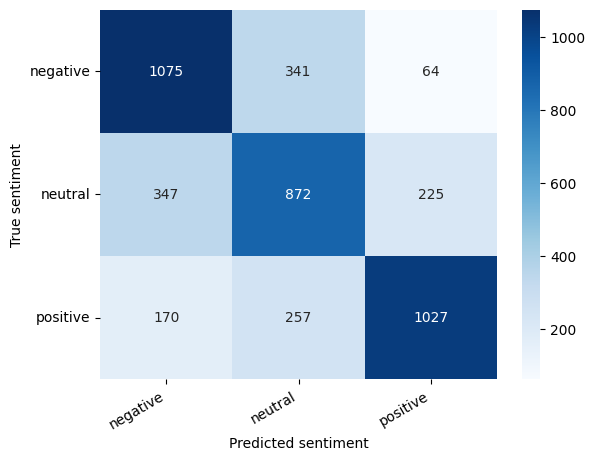

In [ ]:
print("bnb confusion matrix")
cm = confusion_matrix(y_test, pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

# Test Machine Learning

In [ ]:
fasttext_model = FastText.load('/content/drive/MyDrive/Colab Notebooks/PFE/fasttext_model.bin')

In [ ]:
for model in models:
  print("##########")
  print(" testing with",model)
  with open(model, 'rb') as file:
    loaded_model = pickle.load(file)

  test_sentences = ["عجبني هايل", "ماعجبنيش سامط", "نص نص"]
  # Convert the test sentence to Word2Vec embeddings
  for sentence in test_sentences:
    # Convert the test sentence to Word2Vec embeddings
    test_embedding = np.mean([fasttext_model.wv[word] for word in sentence.split() if word in fasttext_model.wv]
                             or [np.zeros(fasttext_model.vector_size)], axis=0)

    # Make prediction using the loaded Logistic Regression model
    predicted_label = loaded_model.predict([test_embedding])

    print(f"Sentence: {sentence}")
    print(f"Predicted label: {predicted_label[0]}")
    print()

##########
 testing with svm.pkl
Sentence: عجبني هايل
Predicted label: 2

Sentence: ماعجبنيش سامط
Predicted label: 1

Sentence: نص نص
Predicted label: 0

##########
 testing with bnb.pkl
Sentence: عجبني هايل
Predicted label: 2

Sentence: ماعجبنيش سامط
Predicted label: 1

Sentence: نص نص
Predicted label: 1



# Deep Learning with three labels

In [ ]:
fasttext_model = FastText.load('/content/drive/MyDrive/Colab Notebooks/PFE/fasttext_model.bin')

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])

In [ ]:
len(tokenizer.word_index) + 1

47800

In [ ]:
max_sequence_length= 300

In [ ]:
X = pad_sequences(sequences, maxlen=max_sequence_length)
y = np.array(df.sentiment.values)

In [ ]:
y = np.eye(len(label_mapping))[y]
y

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=21)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=21)

In [ ]:
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, 300))
for word, i in tokenizer.word_index.items():
  if word in fasttext_model.wv:
    embedding_matrix[i] = fasttext_model.wv[word]
print(embedding_matrix.shape)

In [ ]:
embedding_layer = Embedding(len(tokenizer.word_index) + 1, max_sequence_length, weights=[embedding_matrix], input_length=max_sequence_length, trainable=False)

In [ ]:
def build_model(hp):
  learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])
  dropout_rate = hp.Float('dropout_rate', 0.1, 0.5, step=0.1)

  model = Sequential()
  model.add(embedding_layer)
  model.add(Bidirectional(LSTM(256, dropout=dropout_rate,
                               recurrent_dropout=dropout_rate,
                               return_sequences=True)))
  model.add(GlobalMaxPool1D())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(dropout_rate))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(dropout_rate))
  model.add(Dense(32, activation='relu'))
  model.add(Dropout(dropout_rate))
  model.add(Dense(3, activation='softmax'))

  # Compile the model
  optimizer = Adam(learning_rate=learning_rate)

  model.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

  return model

In [ ]:
# Define the Hyperband tuner
tuner = Hyperband(build_model,
                  objective='val_accuracy',
                  max_epochs=3,
                  factor=3,
                  directory='/content/drive/MyDrive/Colab Notebooks/PFE/wordembedding_hyper_3',
                  project_name='sentiment_analysis')

In [ ]:
tuner.search(x_train, y_train, validation_data=(x_test, y_test), epochs=15)

In [ ]:
best_hps = tuner.get_best_hyperparameters(1)[0]

In [ ]:
print(best_hps.values)

In [ ]:
final_model = tuner.hypermodel.build(best_hps)
final_model.summary()

In [ ]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
history = final_model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=15, callbacks=[early_stopping])

In [ ]:
final_model.save('/content/drive/MyDrive/Colab Notebooks/PFE/fasttext_bilstm_3.h5')

In [ ]:
model = load_model('/content/drive/MyDrive/Colab Notebooks/PFE/fasttext_bilstm_3.h5')

In [ ]:
# Evaluate the final model
loss, accuracy = model.evaluate(x_test, y_test)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

137/137 [==============================] - 29s 184ms/step - loss: 0.5879 - accuracy: 0.7714
Test Loss: 0.5878783464431763
Test Accuracy: 0.7713567614555359


In [ ]:
pred = model.predict(x_test)

137/137 [==============================] - 25s 178ms/step


In [ ]:
pred = np.argmax(pred, axis=1)
y_test_original=np.argmax(y_test, axis=1)

In [ ]:
print("deep learning classification report")
print(classification_report(y_test_original, pred))

deep learning classification report
              precision    recall  f1-score   support

           0       0.78      0.82      0.80      1480
           1       0.68      0.76      0.72      1444
           2       0.89      0.73      0.80      1454

    accuracy                           0.77      4378
   macro avg       0.78      0.77      0.77      4378
weighted avg       0.78      0.77      0.77      4378



deep learning confusion matrix


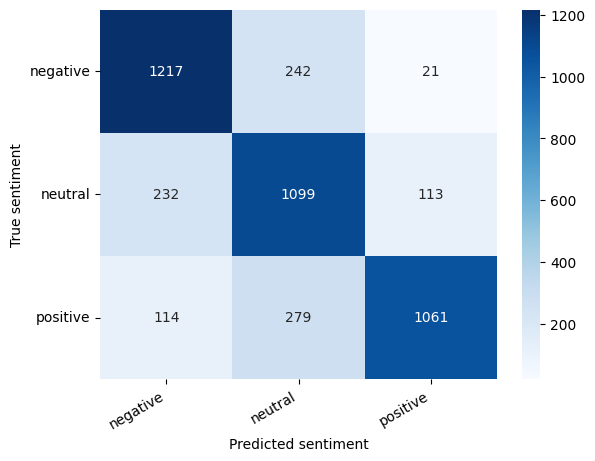

In [ ]:
print("deep learning confusion matrix")
cm = confusion_matrix(y_test_original, pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

## Test

In [ ]:
new_texts = ["حرام غالي بزاف خلي يصدي ", "شحال دير ؟", "بارك الله فيك"]
new_sequences = tokenizer.texts_to_sequences(new_texts)
new_X = pad_sequences(new_sequences, maxlen=max_sequence_length)
predictions = model.predict(new_X)
predicted_labels = np.argmax(predictions, axis=1)
predicted_sentiments = []
for label in predicted_labels:
    sentiment = [key for key, value in label_mapping.items() if value == label][0]
    predicted_sentiments.append(sentiment)
print("Predictions:", predictions)
print("predicted_labels:", predicted_labels)
print('predicted_sentiments:',predicted_sentiments)

1/1 [==============================] - 0s 309ms/step
Predictions: [[9.1581666e-01 6.4815462e-02 1.9367833e-02]
 [2.9902344e-04 9.9861693e-01 1.0839899e-03]
 [9.6622659e-07 2.4764243e-04 9.9975139e-01]]
predicted_labels: [0 1 2]
predicted_sentiments: ['negative', 'neutral', 'positive']


# Deep Learning with two labels

In [ ]:
fasttext_model = FastText.load('/content/drive/MyDrive/Colab Notebooks/PFE/fasttext_model.bin')

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])

In [ ]:
len(tokenizer.word_index) + 1

47800

In [ ]:
max_sequence_length= 300

In [ ]:
X = pad_sequences(sequences, maxlen=max_sequence_length)
y = np.array(df.sentiment.values)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=21)

In [ ]:
x_new = np.empty((0, x_train.shape[1]), x_train.dtype)
y_new = np.empty((0,), y_train.dtype)
for i in range(len(y_train)):
  if y_train[i] != 1:
    #x_train_binary.append(x_train[i])
    x_new = np.vstack((x_new, x_train[i]))
    y_new = np.append(y_new, y_train[i])
    #y_train_binary.append(y_train[i])

In [ ]:
for i in range(len(y_new)):
    if y_new[i] == 2:
        y_new[i] = 1

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_new, y_new, test_size=0.25, random_state=21)

In [ ]:
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, 300))
for word, i in tokenizer.word_index.items():
  if word in fasttext_model.wv:
    embedding_matrix[i] = fasttext_model.wv[word]
print(embedding_matrix.shape)

(47800, 300)


In [ ]:
embedding_layer = Embedding(len(tokenizer.word_index) + 1, max_sequence_length, weights=[embedding_matrix], input_length=max_sequence_length, trainable=False)

In [ ]:
def build_model(hp):
  learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])
  dropout_rate = hp.Float('dropout_rate', 0.1, 0.5, step=0.1)

  model = Sequential()
  model.add(embedding_layer)
  model.add(Bidirectional(LSTM(256, dropout=dropout_rate,
                               recurrent_dropout=dropout_rate,
                               return_sequences=True)))
  model.add(GlobalMaxPool1D())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(dropout_rate))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(dropout_rate))
  model.add(Dense(32, activation='relu'))
  model.add(Dropout(dropout_rate))
  model.add(Dense(1, activation='sigmoid'))

  # Compile the model
  optimizer = Adam(learning_rate=learning_rate)

  model.compile(optimizer=optimizer,
                loss='binary_crossentropy',
                metrics=['accuracy'])

  return model

In [ ]:
# Define the Hyperband tuner
tuner = Hyperband(build_model,
                  objective='val_accuracy',
                  max_epochs=3,
                  factor=3,
                  directory='/content/drive/MyDrive/Colab Notebooks/PFE/wordembedding_hyper_3',
                  project_name='sentiment_analysis')

In [ ]:
#tuner.search(x_train, y_train, validation_data=(x_test, y_test), epochs=15)

In [ ]:
best_hps = tuner.get_best_hyperparameters(1)[0]

In [ ]:
print(best_hps.values)

{'learning_rate': 0.01, 'dropout_rate': 0.1, 'tuner/epochs': 3, 'tuner/initial_epoch': 1, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0001'}


In [ ]:
final_model = tuner.hypermodel.build(best_hps)
final_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          14340000  
                                                                 
 bidirectional (Bidirectiona  (None, 300, 512)         1140736   
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 512)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8

In [ ]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
history = final_model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=15, callbacks=[early_stopping])

Epoch 1/15
274/274 [==============================] - 680s 2s/step - loss: 0.2704 - accuracy: 0.8967 - val_loss: 0.2131 - val_accuracy: 0.9183
Epoch 2/15
274/274 [==============================] - 652s 2s/step - loss: 0.1928 - accuracy: 0.9326 - val_loss: 0.1978 - val_accuracy: 0.9269
Epoch 3/15
274/274 [==============================] - 654s 2s/step - loss: 0.1738 - accuracy: 0.9384 - val_loss: 0.2441 - val_accuracy: 0.9210
Epoch 4/15
274/274 [==============================] - 659s 2s/step - loss: 0.1524 - accuracy: 0.9456 - val_loss: 0.2171 - val_accuracy: 0.9169
Epoch 5/15
274/274 [==============================] - 652s 2s/step - loss: 0.1344 - accuracy: 0.9527 - val_loss: 0.2052 - val_accuracy: 0.9156
Epoch 6/15
274/274 [==============================] - 670s 2s/step - loss: 0.1343 - accuracy: 0.9529 - val_loss: 0.2117 - val_accuracy: 0.9231
Epoch 7/15
274/274 [==============================] - 661s 2s/step - loss: 0.1251 - accuracy: 0.9565 - val_loss: 0.2305 - val_accuracy: 0.9224

In [ ]:
final_model.save('/content/drive/MyDrive/Colab Notebooks/PFE/fasttext_bilstm_2.h5')

In [ ]:
model = load_model('/content/drive/MyDrive/Colab Notebooks/PFE/fasttext_bilstm_2.h5')

In [ ]:
predictions = model.predict(x_test)

In [ ]:
predicted_labels = []
for prob in predictions:
    if prob < 0.33:
        predicted_labels.append(0)
    elif prob > 0.66:
        predicted_labels.append(2)
    else:
        predicted_labels.append(1)

In [ ]:
predicted_labels

In [ ]:
print("svm accuracy: ",accuracy_score(y_test, predicted_labels))
print("svm f1: ",f1_score(y_test, predicted_labels, average='weighted'))

svm accuracy:  0.6388761991777067
svm f1:  0.5595450299370145


In [ ]:
print("mnb classification report")
print(classification_report(y_test, predicted_labels))

mnb classification report
              precision    recall  f1-score   support

           0       0.64      0.93      0.76      1480
           1       0.59      0.10      0.17      1444
           2       0.65      0.88      0.75      1454

    accuracy                           0.64      4378
   macro avg       0.63      0.64      0.56      4378
weighted avg       0.63      0.64      0.56      4378



mnb confusion matrix


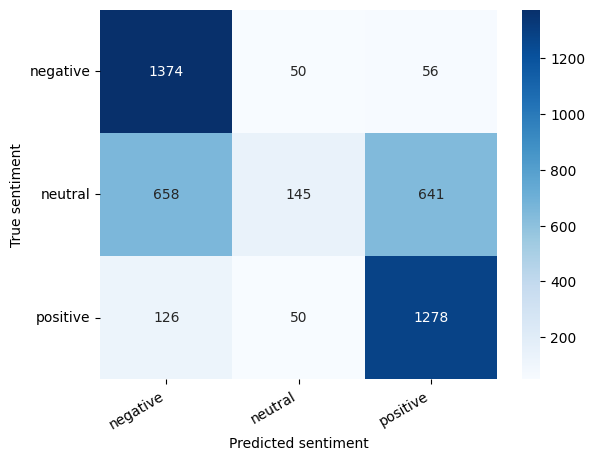

In [ ]:
print("mnb confusion matrix")
cm = confusion_matrix(y_test, predicted_labels)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)